# Preparing the data

In [1]:
import os
#preparing the input data to the gpt model
data_file = "tiny_shakespeare.txt"
input_file = open(data_file, 'r')
input_text = input_file.read()
print(input_text[:100])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [2]:
#getting all the characters of the dataset
chars = sorted(list(set(input_text)))
print(f"{len(chars)} characters in dataset")
print(chars)

65 characters in dataset
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
#creating mapping from character to int and vice versa
char2int = {c:i for i,c in enumerate(chars)}
int2char = {i:c for i,c in enumerate(chars)}
encoder = lambda s: [char2int[c] for c in s]
decoder = lambda l: ''.join([int2char[i] for i in l])

print(f"encoded: {encoder('hello')}")
print(f"decoded: {decoder(encoder('hello'))}")

encoded: [46, 43, 50, 50, 53]
decoded: hello


In [4]:
#coding the text dataset and storing it as a pytorch tensor
import torch
data_tensor = torch.tensor(encoder(input_text), dtype=torch.long)
print(data_tensor.shape, data_tensor.dtype)
print(data_tensor[:100])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [5]:
#splitting the dataset into training and validation sets
train_size = 0.9
train_data = data_tensor[:int(train_size*len(data_tensor))]
val_data = data_tensor[int(train_size*len(data_tensor)):]
print("Training data shape", train_data.shape)
print("Validation data shape", val_data.shape)

Training data shape torch.Size([1003853])
Validation data shape torch.Size([111540])


In [6]:
#defining the max length of the data being fed into the transformer(defined as block_size)
#we are predicting the last character of each block so we have to do block_size+1
block_size = 8
first_block = train_data[:block_size+1]
print(first_block)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


In [7]:
#there are multiple training examples in the single block
x = train_data[:block_size]
y = train_data[1:block_size+1]
print(f"Context: {x} Target: {y}")
for idx in range(block_size):
    context = x[:idx+1]
    target = y[idx]
    print(f"Context: {context} Target: {target}")

Context: tensor([18, 47, 56, 57, 58,  1, 15, 47]) Target: tensor([47, 56, 57, 58,  1, 15, 47, 58])
Context: tensor([18]) Target: 47
Context: tensor([18, 47]) Target: 56
Context: tensor([18, 47, 56]) Target: 57
Context: tensor([18, 47, 56, 57]) Target: 58
Context: tensor([18, 47, 56, 57, 58]) Target: 1
Context: tensor([18, 47, 56, 57, 58,  1]) Target: 15
Context: tensor([18, 47, 56, 57, 58,  1, 15]) Target: 47
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47]) Target: 58


In [8]:
#defining the batches of the data
torch.manual_seed(1337)
batch_size = 4 #number of samples per batch

def get_batch(split="train"):
    #getting a random batch from the test data or the validation data
    data = train_data if split == "train" else val_data
    #making sure we are staying within the length of the data
    idxs = torch.randint(len(data)-block_size, (batch_size,))
    #getting the x and y values for the batch
    xs = [data[idx:idx+block_size] for idx in idxs]
    ys = [data[idx+1:idx+block_size+1] for idx in idxs]
    #concatenating the tesnors and returning as a single tensor
    return torch.stack(xs), torch.stack(ys)
xb, yb = get_batch("train")
print("inputs", xb.shape)
print(xb)
print("targets", yb.shape)
print(yb)
print("_______________")

#testing the batches of the data
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"Context: {context} Target: {target}")
        


inputs torch.Size([4, 8])
tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
targets torch.Size([4, 8])
tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])
_______________
Context: tensor([53]) Target: 59
Context: tensor([53, 59]) Target: 6
Context: tensor([53, 59,  6]) Target: 1
Context: tensor([53, 59,  6,  1]) Target: 58
Context: tensor([53, 59,  6,  1, 58]) Target: 56
Context: tensor([53, 59,  6,  1, 58, 56]) Target: 47
Context: tensor([53, 59,  6,  1, 58, 56, 47]) Target: 40
Context: tensor([53, 59,  6,  1, 58, 56, 47, 40]) Target: 59
Context: tensor([49]) Target: 43
Context: tensor([49, 43]) Target: 43
Context: tensor([49, 43, 43]) Target: 54
Context: tensor([49, 43, 43, 54]) Target: 1
Context: tensor([49, 43, 43, 54,  1]) Target: 47
Context: tensor

# Importing the bigram model

In [9]:
#running the forward pass of the model
from bigram_model import BigramLanguageModel
bm = BigramLanguageModel(len(chars))
out, loss = bm(xb, yb)
print(out.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8948, grad_fn=<NllLossBackward0>)


In [10]:
#running the generate function of the model
idx = torch.zeros((1,1), dtype=torch.long)
print(decoder(bm.generate(idx, 100)[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


# Implementing the training loop for the bigram model

In [11]:
#training loop
optimizer = torch.optim.AdamW(bm.parameters(), lr=1e-3)

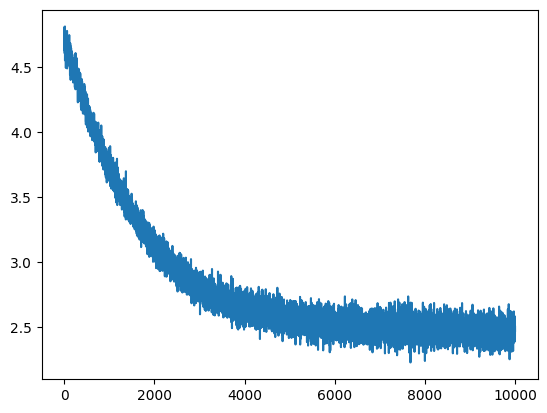

In [12]:
import matplotlib.pyplot as plt

batch_size = 32
losses = []
for steps in range(10000):
    #getting the batch
    xb, yb = get_batch("train")
    #evaluating the loss
    logits, loss = bm(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.show()

In [13]:
#getting the sample output from the bigram model
print(decoder(bm.generate(idx, 1000)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henouratucenonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h haybet--s n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scat t tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN the. sE:
I hisgothers je are! ABer wotouciullle'z,
Thitertho s?
NDan'spererfo cist ripl chys er orlese;
Yo jeh f h hecere ek? wf HEThot mowo soaf loit, ince his, t, f at. fal thetrimy bupof tor atha By!
JOutho f cimimave.
NENTIt cir sella p wie wede
Ro n apenor f'Y toverawitys an sh d w t e w!
CEOntiretoaveEd the we n ck. cung.
ORIsthies hacin benqurd bll, d a r w wistatsowor ath
Fivet bloll ail a-I theeancu,
LINCI'T:
Sarey t I Ane sze t
A hy thit,
n.
Faure ds ppplirn!
meftou ow pring, avewist th;
TENTEMETCo gienco, An he waro whiougou he s i

# Redefining some functions

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
lr = 1e-2
eval_iters = 200

In [15]:
#func for estimated loss so that the loss is less noisy
from tqdm import tqdm

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            losses[i] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_batch(split="train"):
    #getting a random batch from the test data or the validation data
    data = train_data if split == "train" else val_data
    #making sure we are staying within the length of the data
    idxs = torch.randint(len(data)-block_size, (batch_size,))
    #getting the x and y values for the batch
    xs = [data[idx:idx+block_size] for idx in idxs]
    ys = [data[idx+1:idx+block_size+1] for idx in idxs]
    #concatenating the tesnors and returning as a single tensor
    return torch.stack(xs).to(device), torch.stack(ys).to(device)

def train_model(epochs=3000):
    losses = []
    for steps in tqdm(range(epochs)):
    
        #getting the batch
        xb, yb = get_batch("train")
        #evaluating the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # estimated_loss = estimate_loss()
        losses.append(loss.item())
    plt.plot(losses)
    plt.show()

100%|██████████| 30000/30000 [01:17<00:00, 386.21it/s]


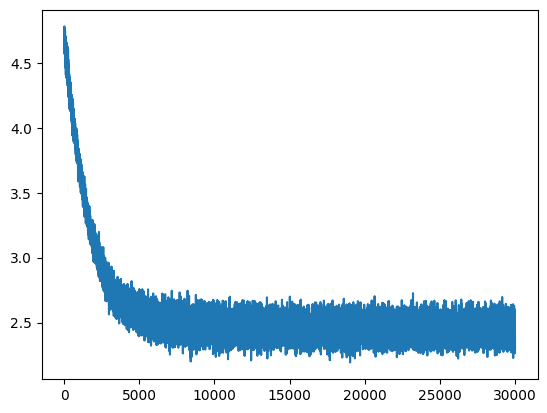

In [16]:
from bigram_model import BigramLanguageModel
model = BigramLanguageModel(len(chars))
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_model(30000)

In [17]:
idx = torch.zeros((1,1), dtype=torch.long).to(device)
print(decoder(model.generate(idx, 1000)[0].tolist()))




CExthy brid owindakis by bth

Hiset bube d e.
S:
O:
IS:
Falatanss:
Wanthar u qur, vet?
F dilasoate awice my.

Hastarom oroup
Yowhthetof isth ble mil ndill, ath iree sengmin lat Heriliovets, and Win nghirileranousel lind me l.
HAshe ce hiry:
Supr aisspllw y.
Hentoul n Boopetelaves
MP:

Pl, d mothakleo Windo whth eisbyo the m dourive we higend t so mower; te

AN ad nterupt f s ar iris! m:

Thiny aleronth,
Mad
RD:

WISo myr f-
LIERor,
SShisar adsal thes ghesthidin cour ay aney Iry ts I fr t ce.
Jonghe nd, bemary.
Yof 'sour menm sora anghy t-e nomangrwe ten.
Wand thot sulin s th llety ome.
I muco ffepyotssthecas l.
TAn.
Mourethal wave.
se ed Pe bene ovetour?
Cassce oros cok hedin tie s inds he te fe f tas ny, ct Clo gscest hes,
A: du he n, soxcone.

NENobeakes aghercobun ws m k s withoumas Fond t s wllo INour id, mersed
Fourd?
TI idurd po venond, d Cad ty
K:
BIUSoou tiund thornofen e sutan wiporthare whanot, sitthers, spe Bllellke, on s h O, t pan, ce wat d tive wout ir f; u;

Feknen ou

# Mathematical trick in self-attention

In [27]:
# consider toy example
torch.manual_seed(1337)
B, T, C = 4,8,2
x = torch.randn(B, T, C)
# we want each token at each time step to only communicate with the tokens in the past
# simplest way of communication is taking the average of tokens in the past
#we want x[b, t] = mean_{t'<t} x[b, t']
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b, t] = torch.mean(xprev, dim=0)
print("first batch in x\n",x[0])
print("first batch in xbow\n",xbow[0])



first element in x
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
first element in xbow
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [28]:
#we can speed the above process up using matrix multiplication
#intro to torch.tril
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [35]:
a = torch.tril((torch.ones((3,3))))
b = torch.randint(0, 10,(3,2)).float()
c = a@b
print("a--")
print(a)
print("b--")
print(b)
print("c--")
print(c)


a--
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b--
tensor([[1., 9.],
        [0., 1.],
        [9., 8.]])
c--
tensor([[ 1.,  9.],
        [ 1., 10.],
        [10., 18.]])


In [36]:
#we can calculate the average by normalizing the "a" matrix
a = torch.tril((torch.ones((3,3))))
a = a/a.sum(dim=1, keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a@b
print("a--")
print(a)
print("b--")
print(b)
print("c--")
print(c)


a--
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b--
tensor([[4., 4.],
        [3., 6.],
        [5., 9.]])
c--
tensor([[4.0000, 4.0000],
        [3.5000, 5.0000],
        [4.0000, 6.3333]])


In [38]:
# now comparing the for loop implementation with the matrix multiplication implementation
# consider toy example
torch.manual_seed(1337)
B, T, C = 4,8,2
x = torch.randn(B, T, C)
# we want each token at each time step to only communicate with the tokens in the past
# simplest way of communication is taking the average of tokens in the past
#we want x[b, t] = mean_{t'<t} x[b, t']
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b, t] = torch.mean(xprev, dim=0)

#w matric => T x T
#x matrix => B x T x C
#xbow matrix => B x T x C
w = torch.tril(torch.ones((T, T)))
w = w/w.sum(dim=1, keepdim=True)
xbow2 = w@x
print(torch.allclose(xbow, xbow2))

True


In [41]:
# another way of doing this
#we can achieve the same thing using softmax
w = torch.zeros((T, T))
tril = torch.tril(torch.ones((T, T)))
w = w.masked_fill(tril==0, float("-inf"))
print(w)

import torch.nn.functional as F
w = F.softmax(w, dim=1)
print(w)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
